In [24]:
# %load gundong_class.py
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdate
from numpy import *
from matplotlib.pylab import rcParams
plt.rcParams['axes.unicode_minus']=False
rcParams['font.sans-serif'] = 'kaiti'

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.stats.diagnostic
from statsmodels.tsa.api import VAR


class gundong():
    def __init__(self, data, gundong_time, k_lag):
        self.row = data.shape[0] # 行长度
        self.column = data.shape[1] # 列长度
        self.data = data
        self.gundong_time = gundong_time # 滚动选择的时间
        self.k_lag = k_lag
        self.save_data_coef = np.zeros((self.column, self.k_lag*self.column, self.row-self.gundong_time+1))
        self.save_data_cov = np.zeros((self.column, self.column, self.row-self.gundong_time+1))
        self.save_data_result = np.zeros((self.column, self.column, self.row-self.gundong_time+1))

        
    
    def VAR(self):
        '''
        实现滚动计算 k-lag 的 VAR 模型
        并且保存矩阵的系数以及相关系数矩阵
        实现了 k-lag>1 时的向量值回归模型
        '''
        for i in range(self.gundong_time, self.row+1,1):
            datai = self.data.iloc[i-self.gundong_time:i,:]
            model = VAR(datai)
            # 滞后 k_lag 个单位计算
            results = model.fit(self.k_lag)
            coef = results.params
            self.save_data_coef[:,:,i-self.gundong_time]= coef.iloc[1:1+self.k_lag*self.column,:].T
            self.save_data_cov[:,:,i-self.gundong_time] = results.sigma_u


    def calculate_A(self, h, coef):
        '''
        从小到大矩阵迭代
        '''
        A_h = mat(np.zeros((self.k_lag*self.column, self.column)))
        A_h[0:self.column, :] = mat(np.identity(self.column))
        matrix_identity = mat(np.zeros((self.k_lag*self.column, self.column)))
        matrix_identity[0:self.column, :] = mat(np.identity(self.column))
        matrix_left = matrix_identity*coef
        matrix_right = mat(np.zeros((self.k_lag*self.column, self.k_lag*self.column)))
        for j in range(1,self.k_lag):
            matrix_right[j*self.column:(j+1)*self.column, (j-1)*self.column:j*self.column] = mat(np.identity(self.column))
        matrix_multiple = matrix_left+matrix_right
        for i in range(h):
            A_h = matrix_multiple*A_h
        return A_h[0:self.column, :]


    def cal_overflow(self, predict_time):
        '''
        适用于不同 k_lag 的向量自回归模型

        predict_time 代表动态预测的天数

        ??? 循环可做矩阵运算优化
        '''
        self.predict_time = predict_time
        for n in range(self.row-self.gundong_time+1):
            coef_data = self.save_data_coef[:,:,n]
            Covariance_mat = self.save_data_cov[:,:,n]
            for i in range(self.column):
                ei = mat(eye(self.column, self.column, dtype=int))[:,i]
                for j in range(self.column):
                    sum_top = 0
                    sum_bottom = 0
                    sigma_jj = Covariance_mat[j,j]
                    ej = mat(eye(self.column, self.column, dtype=int))[:,j]
                    for h in range(self.predict_time):
                        A_h = self.calculate_A(h, coef=coef_data)
                        sum_bottom += ei.T*A_h*Covariance_mat*A_h.T*ei
                        W = ei.T * A_h * Covariance_mat*ej
                        sum_top += 1/sigma_jj * W * W
                    result = sum_top/sum_bottom
                    self.save_data_result[i,j,n] = result
        



    def standard_overflow(self):
        '''
        计算溢出指数的比重

        ??? 循环可做矩阵运算优化
        '''
        for i in range(self.row-self.gundong_time+1):
            sum_line = np.sum(self.save_data_result[:,:,i], axis=1)
            self.save_data_result[:,:,i] = np.divide(self.save_data_result[:,:,i], sum_line)

                
    def save_data(self, path):
        np.save(path+'save_data_coef',self.save_data_coef)
        np.save(path+'save_data_cov',self.save_data_cov)
        np.save(path+'save_data_result',self.save_data_result)
    

    def overflow_matrix(self):
        '''
        对角为 0 的滚动矩阵
        '''
        self.gundongdata = np.zeros(self.row-self.gundong_time+1)
        for i in range(self.row-self.gundong_time+1):
            xishu_i = self.ave_data_result[:,:,i]
            for x in range(self.column):#对角变为0，求非对角元素
                xishu_i[x,x] = 0
            liehe = xishu_i.sum(axis = 0)#列和
            ave = liehe.mean()
            self.gundongdata[i] = ave
        np.save("save_data_result1",self.gundongdata)
    
    def final_data(self):
        '''
        '''
        self.gundongdata1 = pd.DataFrame(columns = ['values'])
        self.gundongdata1['values'] = self.gundongdata[0:self.row-self.gundong_time+1-self.predict_time]
        self.gundongdata1.index = pd.to_datetime(self.data.index[self.gundong_time+self.predict_time-1:])

    def plot_industry(self):
        '''
        '''
        pass


## 标准处理过程

In [3]:
file_path='./now/zong.csv'
data = pd.read_csv(file_path, index_col = 0)

In [25]:
gundong_data = gundong(data, gundong_time=360, k_lag=3)

### 滚动计算VAR模型

In [26]:
gundong_data.VAR()

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

In [10]:
coef = gundong_data.save_data_coef[:,:,1]
column = 11
k_lag = 3


A_h = mat(np.zeros((k_lag*column, column)))
A_h[0:column,:] = mat(np.identity(column))
matrix_identity = mat(np.zeros((k_lag*column, column)))
matrix_identity[0:column, :] = mat(np.identity(column))
matrix_left = matrix_identity*coef
matrix_right = mat(np.zeros((k_lag*column, k_lag*column)))
for j in range(1,k_lag):
    matrix_right[j*column:(j+1)*column, (j-1)*column:j*column] = mat(np.identity(column))
matrix_multiple = matrix_left+matrix_right
for i in range(h):
    A_h = matrix_multiple*A_h

ValueError: shapes (33,11) and (33,11) not aligned: 11 (dim 1) != 33 (dim 0)

In [11]:
A_h = mat(np.zeros((k_lag*column, column)))
A_h[0:column,:] = mat(np.identity(column))
A_h.shape

(33, 11)

In [21]:
def calculate_A(h, coef, column, k_lag):
    '''
    从小到大矩阵迭代
    '''
    A_h = mat(np.zeros((k_lag*column, column)))
    A_h[0:column,0:column] = mat(np.identity(column))
    matrix_identity = mat(np.zeros((k_lag*column, column)))
    matrix_identity[0:column,0:column] = mat(np.identity(column))
    matrix_left = matrix_identity*coef
    matrix_right = mat(np.zeros((k_lag*column, k_lag*column)))
    for j in range(1,k_lag):
        matrix_right[j*column:(j+1)*column, (j-1)*column:j*column] = mat(np.identity(column))
    matrix_multiple = matrix_left+matrix_right
    for i in range(h):
        A_h = matrix_multiple*A_h
    return A_h[0:column,0:column]

calculate_A(10, data_1, 11, 3)

ValueError: shape too large to be a matrix.

### 计算动态预测天数

In [27]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 11 16:44:40 2020

@author: 哎哟喂
"""

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from numpy import *
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.stats.diagnostic
from statsmodels.tsa.api import VAR

save_data_fai1 = np.zeros((11,11,979))
save_data_cov = np.zeros((11,11,979))
save_data_result = np.zeros((11,11,979))
np.save("save_data_fai1",save_data_fai1)
np.save("save_data_cov",save_data_cov)
#save_data[:,:,0].

data= pd.read_csv('./now/zong.csv',index_col='index') 
for i in range(360,1339,1):
    datai = data.iloc[i-360:i,:]
    model = VAR(datai)
    results = model.fit(1)
    coef = results.params
    fai1i = coef.iloc[1:12,:].T#系数书写是得出矩阵的转置
    save_data_fai1[:,:,i-360] = fai1i
    cov = results.sigma_u
    save_data_cov[:,:,i-360] = cov

#递归函数
def caculate_A(i, fai1):
    if i == 0:
        return mat(eye(11,11,dtype=int))
    else:
        return fai1 * caculate_A(i-1,fai1)
# 变量 x_j 对变量 x_i 的向前 H 期的广义预测误差方差   
for n in range(979):
    fai1_data = save_data_fai1[:,:,n]
    Covariance_mat =  save_data_cov[:,:,n]
    for i in range(11): 
        ei = mat(eye(11, 11, dtype=int))[:,i]
        for j in range(11):
            sum_top = 0
            sum_bottom = 0
            sigma_jj = Covariance_mat[j,j]
            ej = mat(eye(11, 11, dtype=int))[:,j]
            # 预期天数为 10 天
            for h in range(10):
                A_h = caculate_A(h, fai1 = fai1_data)
                sum_bottom += ei.T * A_h * Covariance_mat * A_h.T * ei
                W = ei.T * A_h * Covariance_mat * ej
                sum_top += 1 / sigma_jj * W * W
            result = sum_top/sum_bottom
            save_data_result[i,j,n]= result
np.save("save_data_result",save_data_result)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

In [28]:
#行标准化        
import numpy as np
def standard_data(each):
    orig_data = each
    # 计算比重
    sum_line = np.sum(orig_data, axis=1)
    result = np.divide(orig_data,sum_line)
    return sum_line, result
data = np.load("save_data_result.npy")
save_data_result = np.zeros(shape=data.shape)
for i in range(979):
    each = data[:,:,i]
    SUM, result = standard_data(each)
    save_data_result[:,:,i] = result   
    

gundongdata = zeros(979)
for i in range(979):
    xishu_i = save_data_result[:,:,i]
    for x in range(11):#对角变为0，求非对角元素
        xishu_i[x,x] = 0
    liehe = xishu_i.sum(axis = 0)#列和
    ave = liehe.mean()
    gundongdata[i] = ave
np.save("save_data_result1",gundongdata)#保存对角为0的滚动矩阵
'''
series = zeros(980)
for i in range(978):
    series[i] = (gundongdata[i+1]-gundongdata[i])/gundongdata[i]
np.save("D:/liquidity/shujv/daima/k",series)
k = np.load("D:/liquidity/shujv/daima/k.npy")
k1 = abs(k)
k1.sort()
k1[979]
print (np.where(k==0.8823306709948058))
'''

'\nseries = zeros(980)\nfor i in range(978):\n    series[i] = (gundongdata[i+1]-gundongdata[i])/gundongdata[i]\nnp.save("D:/liquidity/shujv/daima/k",series)\nk = np.load("D:/liquidity/shujv/daima/k.npy")\nk1 = abs(k)\nk1.sort()\nk1[979]\nprint (np.where(k==0.8823306709948058))\n'

In [31]:
data= pd.read_csv('./now/zong.csv',index_col='index') 
gundongdata = gundongdata[0:969]
gundongdata1 = pd.DataFrame(columns = ['values'])
gundongdata1['values'] = gundongdata
#转换索引为datatimeindex形式才能画图
gundongdata1.index = pd.to_datetime(data.index[369:])

In [32]:
gundongdata1

,values
index,
2015-07-08,0.552990
2015-07-09,0.550845
2015-07-10,0.543097
2015-07-13,0.543015
2015-07-14,0.543112
...,...
2019-06-24,0.693188
2019-06-25,0.693076
2019-06-26,0.693824


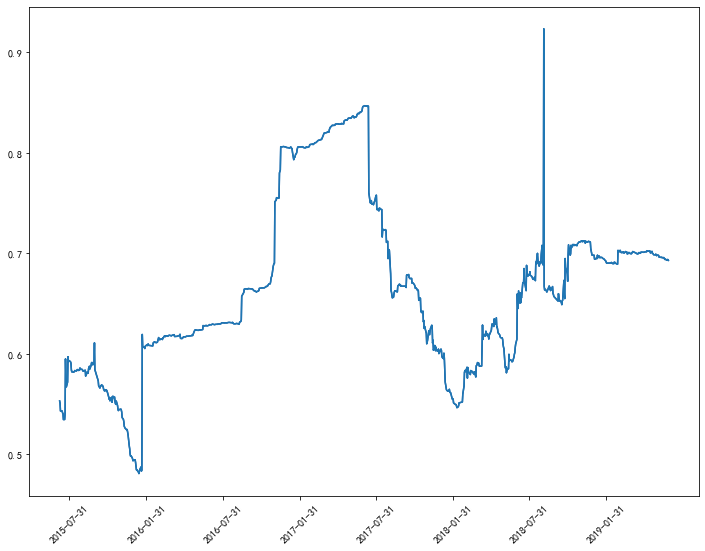

In [33]:
#画出滚动360天，预测10天的全国动态图
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from matplotlib.pyplot import rcParams 
rcParams['font.sans-serif'] = 'kaiti'
#???坐标显示问题
values = gundongdata1['values']
time = gundongdata1.index
fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#显示日期
plt.xticks(pd.date_range(time[0],time[-1],freq='6M'),rotation=45)
ax.plot(time,values,color='#054E9F')

plt.plot(gundongdata1)
plt.show()

In [38]:
#画出滚动360天，预测10天的公用事业动态图
gundonggongyong = zeros(979)
for i in range(979):
    xishu_i = save_data_result[:,:,i]
    for x in range(11):#对角变为0，求非对角元素
        xishu_i[x,x] = 0
    out_ = xishu_i.sum(axis = 0)[4]#第5列和（公用事业列）
    in_ = xishu_i.sum(axis = 1)[4]#第5行和
    net = out_ - in_
    gundonggongyong[i] = net

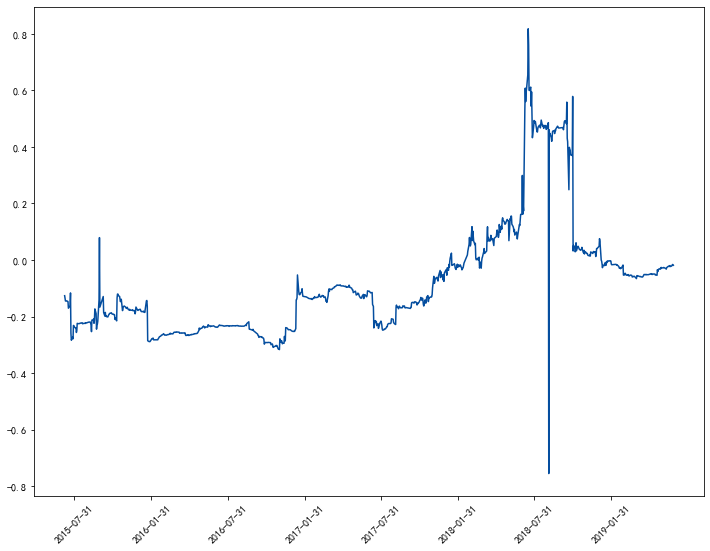

In [40]:
gundonggongyong1 = pd.DataFrame(columns = ['values'])
gundonggongyong1['values'] = gundonggongyong[0:969]

#转换索引为datatimeindex形式才能画图
gundonggongyong1.index = pd.to_datetime(data.index[369:])

import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from matplotlib.pyplot import rcParams 
plt.rcParams['axes.unicode_minus']=False
rcParams['font.sans-serif'] = 'kaiti'
values = gundonggongyong1['values']
time = gundonggongyong1.index
fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#显示日期
plt.xticks(pd.date_range(time[0],time[-1],freq='6M'),rotation=45)
ax.plot(time,values,color='#054E9F')